In [1]:
import numpy.random as random
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# 4 - Assignment Part 2

In [2]:
def mackey_glass(t, mg_dict, beta=0.2, gamma=0.1, n=10, r=25):
    if t == 0:
        return 1.5
    elif t < 0:
        return 0

    if mg_dict.get(t):
        return mg_dict.get(t)

    t_prev = t - 1

    if not mg_dict.get(t_prev):
        mg_dict[t_prev] = mackey_glass(t_prev, mg_dict)

    mg_t = mg_dict.get(t_prev)

    if not mg_dict.get(t_prev - r):
        mg_dict[t_prev - r] = mackey_glass(t_prev - r, mg_dict)

    mg_tr = mg_dict.get(t_prev - r)

    return mg_t + (beta * mg_tr) / (1 + mg_tr ** n) - gamma * mg_t

mg_dict = {}
input = []
output = []
for t in range(300, 1500):
    input.append([mackey_glass(t-20, mg_dict), mackey_glass(t-15, mg_dict), mackey_glass(t-10, mg_dict), mackey_glass(t-5, mg_dict), mackey_glass(t, mg_dict), 1])
    output.append(mackey_glass(t+5, mg_dict))

input = np.array(input)
output = np.array(output)


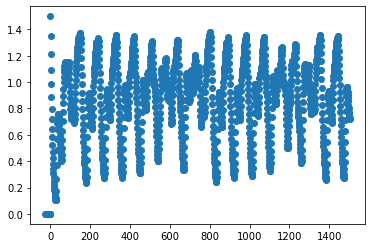

In [3]:
plt.scatter(mg_dict.keys(), mg_dict.values())
plt.show()

In [6]:
# consecutive blocks of the time series: train -> val -> test
X_train_val, X_test, y_train_val, y_test = train_test_split(input, output, test_size=200, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)


In [ ]:
regressor = MLPRegressor(random_state=1, max_iter=500, solver="sgd", early_stopping=True, validation_fraction=0.2)
regressor.fit(X_train, y_train)


In [ ]:
def create_network(hidden_layers=[5], activation="relu", final_activation="linear", input_shape=(5,), output_shape=1):
    model = Sequential()
    for i, nodes in enumerate(hidden_layers):
        if i == 0:
            model.add(Dense(nodes, input_shape=input_shape, activation=activation))
        else:
            model.add(Dense(nodes, activation=activation))
    model.add(Dense(output_shape, activation=final_activation))
    return model


model = create_network()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=150, batch_size=10)

_, accuracy = model.evaluate(X_val, y_val)
print('Accuracy: %.2f' % (accuracy*100))